# Experiments on Quantization (ResNet)

- Jira: http://jira-msc.rnd.huawei.com/browse/AEE-177
- Base: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
- Also: resnet.ipynb

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pyraul.pipeline.train_step import train_step
from pyraul.tools.dataset import Dataset
from pyraul.tools.dumping import dump_weights, gen_cpp_dtVec, size
%matplotlib inline

## Quantization

There are different methods of quantization techniques that are used in neural networks.

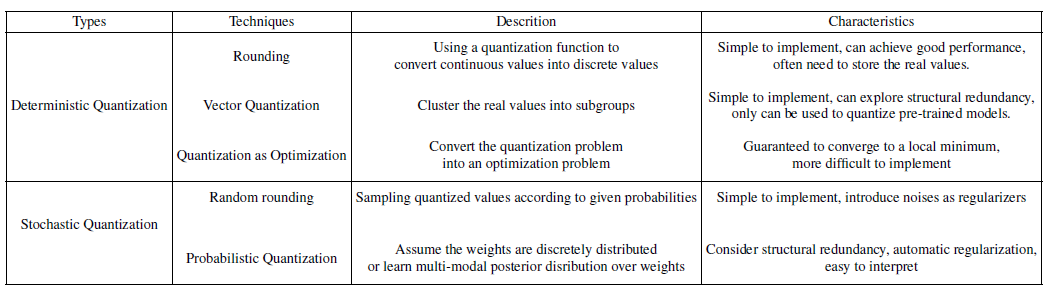
Y. Guo, “A Survey on Methods and Theories of Quantized Neural Networks,” arXiv:1808.04752 [cs, stat], Dec. 2018, Accessed: May 06, 2020. [Online]. Available: http://arxiv.org/abs/1808.04752.

**Affine quantization**

Here we use an affine rounding quantization method which can be defined as follow.

Quantization:
$$
y_q = \lfloor x_f s + y_{0} \rceil.
$$

Dequantization:
$$
x_f' = \frac{y_q}{s}  - y_{0}.
$$

**Symmetric quantization**

The symmetric quantization is defined as
$$
y_q = \lfloor x_f s \rceil
$$

and dequantization as
$$
x_f' = \frac{y_q}{s},
$$

where scale factor in restricted mode is 

$$
s = \frac{2^{n-1}-1}{\max(|x_f|)},
$$

where n is a number of bits.

See https://nervanasystems.github.io/distiller/algo_quantization.html

### Implementation of quantization

In [2]:
from functools import partial
from typing import Optional, Callable, Tuple

def clamp(x_float: torch.Tensor, min_float: float, max_float: float) -> torch.Tensor:
    return max(min(x_float, max_float), min_float)

def quantize_affine(x_float: torch.Tensor, round_func: Callable, scale_value: float, offset_value: float, limits_float:Optional[tuple]=None) -> torch.Tensor:
    if limits_float:
        min_float = limits_float[0]
        max_float = limits_float[1]
        x_float = clamp(x_float, min_float, max_float)
    value_offsetted = x_float + offset_value
    value_scaled = value_offsetted*scale_value
    return round_func(value_scaled)

def dequantize_affine(x_float: torch.Tensor, round_func: Callable, scale_value: float, offset_value: float) -> torch.Tensor:
    return x_float/scale_value - offset_value

def get_symmetric_range(x_float, n: int = 8):
    max_abs_value = torch.max(torch.abs(x_float))
    scale = (2.0**(n-1)-1.0)/max_abs_value
    return  -max_abs_value, max_abs_value

def get_symmetric_funcs(x_float: torch.Tensor, round_func: Callable, n: int = 8, limits_float:Optional[tuple]=None) -> Tuple[Callable, Callable]:
    max_abs_value = torch.max(torch.abs(x_float))
    scale = (2.0**(n-1)-1.0)/max_abs_value
    quant_func = partial(quantize_affine, round_func=round_func, scale_value=scale, offset_value=0.0, limits_float=limits_float)
    dequant_func = partial(dequantize_affine, round_func=round_func, scale_value=scale, offset_value=0.0)
    return quant_func, dequant_func

def round_towards_zero(x: torch.Tensor) -> torch.Tensor:
    y = x.clone()
    y[x>=0] = torch.floor(x[x>=0])
    y[x<0] = torch.ceil(x[x<0])
    return y

### Visualization of quantization

In [3]:
data = lambda n, max_val=100.0, min_val=-100.0: torch.arange(min_val,max_val, (max_val-min_val)/n)
float_tensor = torch.Tensor(data(100))
quant_8, dequnt_8 = get_symmetric_funcs(float_tensor, round_towards_zero, n=8)
quant_4, dequnt_4 = get_symmetric_funcs(float_tensor, round_towards_zero, n=4)
quant_2, dequnt_2 = get_symmetric_funcs(float_tensor, round_towards_zero, n=2)
FakeQuant8 = lambda x: dequnt_8(quant_8(x))
FakeQuant4 = lambda x: dequnt_4(quant_4(x))
FakeQuant2 = lambda x: dequnt_2(quant_2(x))
quant_tensor_8 = FakeQuant8(float_tensor)
quant_tensor_4 = FakeQuant4(float_tensor)
quant_tensor_2 = FakeQuant2(float_tensor)

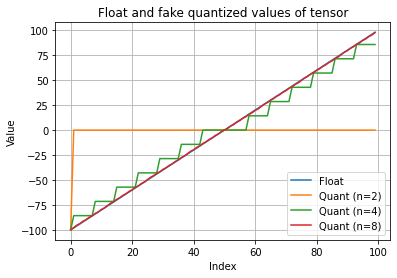

In [4]:
plt.title('Float and fake quantized values of tensor')
plt.grid(True)
plt.ylabel('Value')
plt.xlabel('Index')
plt.plot(float_tensor, label="Float")
plt.plot(quant_tensor_2, label="Quant (n=2)")
plt.plot(quant_tensor_4, label="Quant (n=4)")
plt.plot(quant_tensor_8, label="Quant (n=8)")
plt.legend(loc='lower right')

### FakeQuantLayer

In [26]:
class FakeQuantF(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, n=8):
        ctx.save_for_backward(input)
        ctx.n = n
        if n:
            y = input.clone()
            for idx in range(input.size(0)):
                quant, dequnt = get_symmetric_funcs(input[idx], round_towards_zero, n=n)
                y[idx] = dequnt(quant(input[idx]))
            return y
        return input

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        if ctx.n:
            grad_inputs = grad_output.clone()
            for idx in range(input.size(0)):
                range_min, range_max = get_symmetric_range(input[idx], ctx.n)
                grad_inputs[idx][input[idx]<range_min] = 0.0
                grad_inputs[idx][input[idx]>range_max] = 0.0
            return grad_inputs, None
        return grad_output, None


class FakeQuant(nn.Module):
    def __init__(self, n=8):
        super().__init__()
        self._n = n
    def forward(self, x):
        return FakeQuantF.apply(x, self._n)

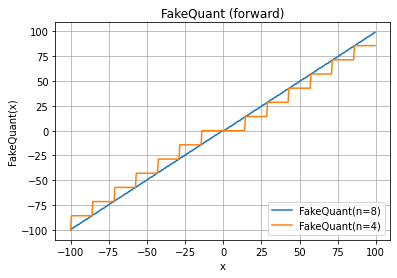

In [27]:
x = torch.from_numpy(np.arange(-100.0, 100.0, 0.5, dtype=np.float32))
x = torch.stack([x], 0)
q8_result = FakeQuant(n=8).eval()(x)
q4_result = FakeQuant(n=4).eval()(x)
plt.title('FakeQuant (forward)')
plt.grid(True)
plt.ylabel('FakeQuant(x)')
plt.xlabel('x')
plt.plot(x[0], q8_result[0], label="FakeQuant(n=8)")
plt.plot(x[0], q4_result[0], label="FakeQuant(n=4)")
plt.legend(loc='lower right')

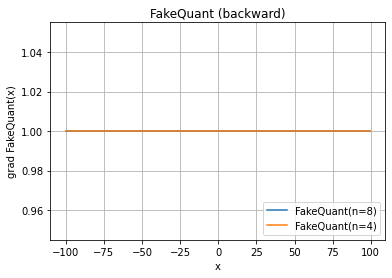

In [7]:
def get_grad(function, input_x):
    x = input_x.clone().requires_grad_(True)
    y = function.train()(x)
    y = y.sum()
    y.backward()
    return x.grad

x_grad = torch.from_numpy(np.arange(-100.0, 100.0, 0.5, dtype=np.float32))
x_grad = torch.stack([x_grad], 0)
q8_grad_y = get_grad(FakeQuant(n=8), x_grad)
q4_grad_y = get_grad(FakeQuant(n=4), x_grad)

plt.title('FakeQuant (backward)')
plt.grid(True)
plt.ylabel('grad FakeQuant(x)')
plt.xlabel('x')
plt.plot(x_grad[0], q8_grad_y[0], label="FakeQuant(n=8)")
plt.plot(x_grad[0], q4_grad_y[0], label="FakeQuant(n=4)")
plt.legend(loc='lower right')

## Experiments on ResNet

In [8]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

### BasicBlock

In [30]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, quantization=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.fk = FakeQuant(quantization)
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        x = self.fk(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.fk(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

### ResNet architecture

In [17]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, quantization=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        
        self.fk = FakeQuant(quantization)
        self.quantization = quantization

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.original_weights_storage = {}

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1

        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                self.fk,
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer, quantization=self.quantization))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer, quantization=self.quantization))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        # Note: skip the first convolution (convention)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x
    
    def save_weights(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d) and "layer" in name:
                self.original_weights_storage[name] = module.weight.data.clone()
                
    def load_weights(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d) and "layer" in name:
                module.weight.data.copy_(self.original_weights_storage[name])
                
    def quantize_weigths(self, n=8):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d) and "layer" in name:
                quant, dequnt = get_symmetric_funcs(module.weight.data, round_towards_zero, n=n)
                module.weight.data.copy_(dequnt(quant(module.weight.data)))

    def forward(self, x):
        if self.quantization:
            self.save_weights()
            self.quantize_weigths()
        y = self._forward_impl(x)
        if self.quantization:
            self.load_weights()
        return y

### ResNet Types

In [11]:
def resnet18(**kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    """
    return ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)

def resnet34(**kwargs):
    r"""ResNet-34 moodel from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    """
    return ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)

def resnet50(**kwargs):
    r"""ResNet-50 moodel from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    """
    return ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)

def resnet101(**kwargs):
    r"""ResNet-101 moodel from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    """
    return ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)

def resnet152(**kwargs):
    r"""ResNet-152 moodel from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    """
    return ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)

### Classifer training experiments with CIFAR10

In [12]:
class Classifier(nn.Module):
    def __init__(self, quantization=None):
        super().__init__()
        self.resnet = resnet18(num_classes=10, quantization=quantization)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, x):
        x = self.resnet(x)
        x = self.softmax(x)
        return x

#### Pretrain: train up to 80% accuracy

In [ ]:
from pyraul.tools.seed import set_seed
import torchvision.transforms as transforms
from pyraul.tools.dataset import Dataset
from pyraul.pipeline import accuracy
from pyraul.pipeline.train_step import train_step
from pyraul.tools.dumping import save_checkpoint

config = {
    "seed": 0,
    "classes": 10,
    "bias": True,
    "batch_size": 50,
    "device": "cuda",
#     "device": "cpu",
    "epochs": 20,
    "sgd": {"lr": 0.05}
}

set_seed(config["seed"])

device = torch.device(config["device"])
model = Classifier(quantization=None)
model = model.to(device)

ds= Dataset("CIFAR10",
            train_transform=[transforms.Resize(224, interpolation=0), transforms.ToTensor()],
            test_transform=[transforms.Resize(224, interpolation=0), transforms.ToTensor()],
            **config)
# optimizer = torch.optim.SGD(model.parameters(), lr=config["sgd"]["lr"])
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.NLLLoss(reduction="mean")

accuracy_before = accuracy(
        model=model,
        dataloader=ds.test_loader,
        **config,
)

print(accuracy_before)

acc_history=[accuracy_before]
loss_history=[]

epochs = config["epochs"]
for epoch in range(1, epochs+1):
        print(f"Epoch: {epoch:03}/{epochs:03}")
        loss, _, _ = train_step(
                            ds.train_loader, 
                            model,
                            criterion,
                            optimizer,
                            device,
                            print_freq=100,
                            verbose=True,
                            loss_history=True
                        )

        loss_history += loss.history
        
        accuracy_after = accuracy(
            model=model,
            dataloader=ds.test_loader,
            **config,
        )
        print(accuracy_after)
        acc_history.append(accuracy_after)
        
        save_checkpoint({"epoch": epoch,
                         "acc": accuracy_after, 
                         "acc_history": acc_history,
                         "loss_history": loss_history,
                         "model_state_dict": model.state_dict(),
                         "optimizer_state_dict": optimizer.state_dict()
                        }, filename=f"checkpoint_quant_{epoch}")

#### Pretrain: train up to higher accuracy

In [50]:
import torch
from pyraul.tools.dumping import dump_weights, DumpMode
from pyraul.tools.seed import set_seed
import torchvision.transforms as transforms
from pyraul.tools.dataset import Dataset
from pyraul.pipeline import accuracy
from pyraul.pipeline.train_step import train_step

config = {
    "seed": 0,
    "classes": 10,
    "bias": True,
    "batch_size": 50,
    "device": "cuda",
#     "device": "cpu",
    "epochs": 10,
    "sgd": {"lr": 0.05}
}

set_seed(config["seed"])

device = torch.device(config["device"])
model = Classifier(quantization=None)
model = model.to(device)

state = torch.load("checkpoint_quant_15")
model.load_state_dict(state["model_state_dict"])
acc_history = state["acc_history"]
loss_history = state["loss_history"]

# dump_weights(model, "83.24.txt", mode=DumpMode.flatten_transpose)
# dump_weights(model, "83.24.txt", mode=DumpMode.transpose_flatten, filter="fc")

ds= Dataset("CIFAR10",
            train_transform=[transforms.Resize(224, interpolation=0), transforms.ToTensor()],
            test_transform=[transforms.Resize(224, interpolation=0), transforms.ToTensor()],
            **config)
optimizer = torch.optim.SGD(model.parameters(), lr=config["sgd"]["lr"])
# optimizer = torch.optim.Adam(model.parameters())
criterion = nn.NLLLoss(reduction="mean")

accuracy_before = accuracy(
        model=model,
        dataloader=ds.test_loader,
        **config,
)

print(accuracy_before)

epochs = config["epochs"]
for epoch in range(1, epochs+1):
    print(f"Epoch: {epoch:03}/{epochs:03}")
    loss, _, _ = train_step(
                        ds.train_loader, 
                        model,
                        criterion,
                        optimizer,
                        device,
                        print_freq=100,
                        verbose=True,
                        loss_history=True
                    )

    accuracy_after = accuracy(
        model=model,
        dataloader=ds.test_loader,
        **config,
    )
    print(accuracy_after)
    
    save_checkpoint({"epoch": epoch,
                         "acc": accuracy_after, 
                         "acc_history": acc_history,
                         "loss_history": loss_history,
                         "model_state_dict": model.state_dict(),
                         "optimizer_state_dict": optimizer.state_dict()
                        }, filename=f"checkpoint_quant_sgd_{epoch}")

INFO: Loading CIFAR10 dataset...


Files already downloaded and verified
Files already downloaded and verified
83.66
Epoch: 001/010
Step    0/1000	Loss: 0.029962 (0.029962)	Time.step: 0.100 (0.100)	Time.load: 0.024 (0.024)
Step  100/1000	Loss: 0.003117 (0.034593)	Time.step: 0.102 (0.102)	Time.load: 0.024 (0.025)
Step  200/1000	Loss: 0.005737 (0.037297)	Time.step: 0.101 (0.102)	Time.load: 0.024 (0.025)
Step  300/1000	Loss: 0.100371 (0.038710)	Time.step: 0.101 (0.102)	Time.load: 0.024 (0.025)
Step  400/1000	Loss: 0.036345 (0.037938)	Time.step: 0.103 (0.102)	Time.load: 0.025 (0.025)
Step  500/1000	Loss: 0.005268 (0.034694)	Time.step: 0.102 (0.102)	Time.load: 0.025 (0.025)
Step  600/1000	Loss: 0.014018 (0.032918)	Time.step: 0.102 (0.102)	Time.load: 0.025 (0.025)
Step  700/1000	Loss: 0.002455 (0.031665)	Time.step: 0.102 (0.103)	Time.load: 0.024 (0.025)
Step  800/1000	Loss: 0.001954 (0.029115)	Time.step: 0.102 (0.103)	Time.load: 0.024 (0.025)
Step  900/1000	Loss: 0.008290 (0.027172)	Time.step: 0.102 (0.103)	Time.load: 0.024 (

#### Quantized ResNet training

In [33]:
import torch
from pyraul.tools.dumping import dump_weights, DumpMode
from pyraul.tools.seed import set_seed
import torchvision.transforms as transforms
from pyraul.tools.dataset import Dataset
from pyraul.pipeline import accuracy
from pyraul.pipeline.train_step import train_step

config = {
    "seed": 0,
    "classes": 10,
    "bias": True,
    "batch_size": 50,
    "device": "cuda",
#     "device": "cpu",
    "epochs": 3,
    "sgd": {"lr": 0.05}
}

set_seed(config["seed"])

device = torch.device(config["device"])
model = Classifier(quantization=8)
model = model.to(device)

state = torch.load("checkpoint_quant_sgd_5")
model.load_state_dict(state["model_state_dict"])

# print(model)

# dump_weights(model, "85.94.txt", mode=DumpMode.flatten_transpose)
# dump_weights(model, "85.94.txt", mode=DumpMode.transpose_flatten, filter="fc")

ds= Dataset("CIFAR10",
            train_transform=[transforms.Resize(224, interpolation=0), transforms.ToTensor()],
            test_transform=[transforms.Resize(224, interpolation=0), transforms.ToTensor()],
            **config)
optimizer = torch.optim.SGD(model.parameters(), lr=config["sgd"]["lr"])
# optimizer = torch.optim.Adam(model.parameters())
criterion = nn.NLLLoss(reduction="mean")

accuracy_before = accuracy(
        model=model,
        dataloader=ds.test_loader,
        **config,
)

print(accuracy_before)

epochs = config["epochs"]
for epoch in range(1, epochs+1):
    print(f"Epoch: {epoch:03}/{epochs:03}")
    loss, _, _ = train_step(
                        ds.train_loader, 
                        model,
                        criterion,
                        optimizer,
                        device,
                        print_freq=100,
                        verbose=True,
                        loss_history=True
                    )

    accuracy_after = accuracy(
        model=model,
        dataloader=ds.test_loader,
        **config,
    )
    print(accuracy_after)

INFO: Loading CIFAR10 dataset...


Files already downloaded and verified
Files already downloaded and verified
84.81
Epoch: 001/003
Step    0/1000	Loss: 0.002460 (0.002460)	Time.step: 1.003 (1.003)	Time.load: 0.033 (0.033)
Step  100/1000	Loss: 0.000686 (0.004624)	Time.step: 0.999 (1.014)	Time.load: 0.030 (0.035)
Step  200/1000	Loss: 0.003546 (0.005127)	Time.step: 1.052 (1.008)	Time.load: 0.038 (0.034)
Step  300/1000	Loss: 0.002742 (0.005304)	Time.step: 0.952 (1.003)	Time.load: 0.024 (0.033)
Step  400/1000	Loss: 0.008159 (0.005235)	Time.step: 0.958 (0.990)	Time.load: 0.023 (0.031)
Step  500/1000	Loss: 0.001392 (0.005103)	Time.step: 0.981 (0.982)	Time.load: 0.030 (0.031)
Step  600/1000	Loss: 0.001523 (0.005074)	Time.step: 0.971 (0.976)	Time.load: 0.024 (0.030)
Step  700/1000	Loss: 0.000271 (0.005018)	Time.step: 0.970 (0.974)	Time.load: 0.024 (0.030)
Step  800/1000	Loss: 0.001588 (0.004737)	Time.step: 0.941 (0.970)	Time.load: 0.026 (0.030)
Step  900/1000	Loss: 0.000977 (0.004499)	Time.step: 0.967 (0.967)	Time.load: 0.031 (

ResNet18 **without** FakeQuant and quantized weights (Adam) shows:
acc after 10 epoch: 83.24
acc after 11 epoch: 83.67

ResNet18 **with** FakeQuant and quantized weights (SGD) shows:
acc after 10 epoch: 82.72
acc after 11 epoch: 85.23

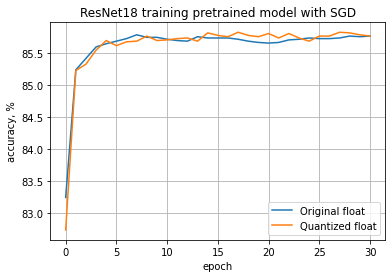

In [42]:
data_float = [
    83.24,
85.24,
85.42,
85.6,
85.65,
85.69,
85.73,
85.79,
85.75,
85.75,
85.72,
85.7,
85.69,
85.76,
85.74,
85.74,
85.74,
85.72,
85.69,
85.67,
85.66,
85.67,
85.71,
85.72,
85.74,
85.73,
85.73,
85.74,
85.77,
85.76,
85.77
]

data_quantized = [
    82.73,
85.23,
85.33,
85.55,
85.7,
85.62,
85.68,
85.69,
85.77,
85.7,
85.71,
85.73,
85.74,
85.69,
85.82,
85.78,
85.76,
85.83,
85.78,
85.76,
85.81,
85.74,
85.81,
85.74,
85.69,
85.77,
85.77,
85.83,
85.82,
85.79,
85.77
]

plt.title('ResNet18 training pretrained model with SGD')
plt.grid(True)
plt.ylabel('accuracy, %')
plt.xlabel('epoch')
plt.plot(data_float,label="Original float")
plt.plot(data_quantized,label="Quantized float")
plt.legend(loc='lower right')
plt.savefig("resnet18_acc_float_quant.png")

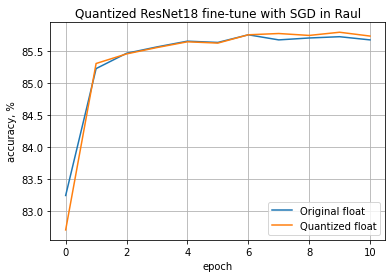

In [7]:
data_float = [
83.24,
85.23,
85.47,
85.57,
85.66,
85.64,
85.76,
85.68,
85.71,
85.73,
85.68
]

data_quantized = [
82.70,
85.31,
85.46,
85.56,
85.65,
85.63,
85.76,
85.78,
85.75,
85.80,
85.74
]

plt.title('Quantized ResNet18 fine-tune with SGD in Raul')
plt.grid(True)
plt.ylabel('accuracy, %')
plt.xlabel('epoch')
plt.plot(data_float,label="Original float")
plt.plot(data_quantized,label="Quantized float")
plt.legend(loc='lower right')
plt.savefig("resnet18_acc_float_quant_raul.png")

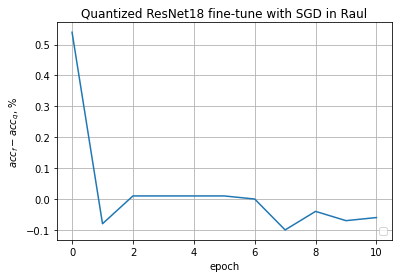

In [13]:
data_diff = [x-y for x,y in zip(data_float, data_quantized)]
plt.title('Quantized ResNet18 fine-tune with SGD in Raul')
plt.grid(True)
plt.ylabel('$acc_f - acc_q$, %')
plt.xlabel('epoch')
plt.plot(data_diff)
plt.legend(loc='lower right')
plt.savefig("resnet18_acc_float_quant_raul_diff.png")

##### Reports

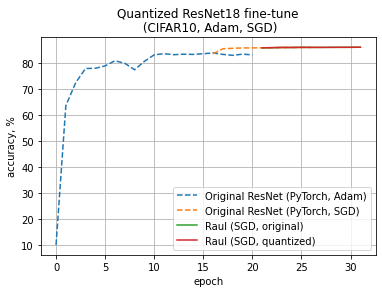

In [32]:
from matplotlib.ticker import MaxNLocator

data_pytorch_adam_full = [
10.0,
63.68,
72.49,
77.97,
78.05,
78.98,
80.95,
79.99,
77.48,
80.73,
83.24,
83.67,
83.29,
83.48,
83.4,
83.66, # we take this
83.96,
83.4,
83.04,
83.51,
83.2
]

data_pytorch_sgd= [
83.66,
85.58,
85.76,
85.89,
85.91,
85.94, # we take this
85.99,
86.06,
86.07,
86.1,
86.1
]

data_pytorch_adam_15 = data_pytorch_adam_full[:15]

data_pytorch_pretrained = data_pytorch_adam_15 + data_pytorch_sgd 

data_raul_sgd_original = [
85.94,
86.00,
86.07,
86.07,
86.11,
86.10,
86.10,
86.12,
86.13,
86.14,
86.16
]

data_raul_sgd_quantized = [
84.76,
86.00,
86.00,
86.06,
86.11,
86.07,
86.11,
86.08,
86.09,
86.09,
86.14
]

plt.title('Quantized ResNet18 fine-tune\n (CIFAR10, Adam, SGD)')
plt.grid(True)
plt.ylabel('accuracy, %')
plt.xlabel('epoch')
plt.plot(range(len(data_pytorch_adam_full)),data_pytorch_adam_full, '--', label="Original ResNet (PyTorch, Adam)")
plt.plot(range(16,16+len(data_pytorch_sgd)),data_pytorch_sgd, '--', label="Original ResNet (PyTorch, SGD)")
plt.plot(range(16+5,16+5+len(data_raul_sgd_original)),data_raul_sgd_original, label="Raul (SGD, original)")
plt.plot(range(16+5,16+5+len(data_raul_sgd_quantized)),data_raul_sgd_original, label="Raul (SGD, quantized)")
plt.legend(loc='lower right')

plt.savefig("resnet18_acc_pytorch_raul.png")

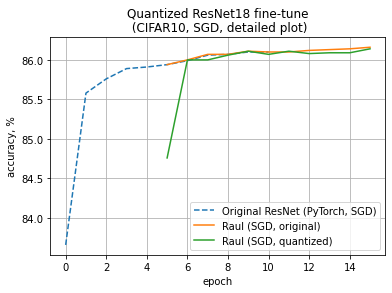

In [29]:
plt.title('Quantized ResNet18 fine-tune\n (CIFAR10, SGD, detailed plot)')
plt.grid(True)
plt.ylabel('accuracy, %')
plt.xlabel('epoch')
plt.plot(range(len(data_pytorch_sgd)),data_pytorch_sgd, '--', label="Original ResNet (PyTorch, SGD)")
plt.plot(range(5,5+len(data_raul_sgd_original)), data_raul_sgd_original, label="Raul (SGD, original)")
plt.plot(range(5,5+len(data_raul_sgd_quantized)), data_raul_sgd_quantized, label="Raul (SGD, quantized)")
plt.legend(loc='lower right')
plt.savefig("resnet18_acc_pytorch_raul_detailed.png")

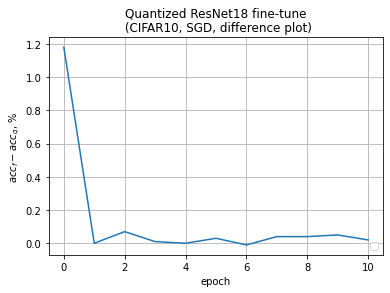

In [31]:
data_diff = [x-y for x,y in zip(data_raul_sgd_original, data_raul_sgd_quantized)]
plt.title('Quantized ResNet18 fine-tune\n (CIFAR10, SGD, difference plot)')
plt.grid(True)
plt.ylabel('$acc_f - acc_q$, %')
plt.xlabel('epoch')
plt.plot(data_diff)
plt.legend(loc='lower right')
plt.savefig("resnet18_acc_pytorch_raul_diff.png")

In [14]:
%load_ext watermark
%watermark -d -u -v -iv

torch 1.4.0
numpy 1.18.1
last updated: 2020-06-09 

CPython 3.8.0
IPython 7.13.0
